An example notebook showing how to train a DECI model on [CSuite](https://github.com/microsoft/csuite) Data.

This demonstrates how to assemble the various components of the library and how to perform training.

In [1]:
import os
from dataclasses import dataclass

import networkx as nx
import pytorch_lightning as pl
import torch
from tensordict import TensorDict
from torch.utils.data import DataLoader

from causica.datasets.causica_dataset_format import DataEnum, load_data
from causica.datasets.tensordict_utils import tensordict_shapes
from causica.distributions import (
    AdjacencyDistribution,
    ContinuousNoiseDist,
    DistributionModule,
    ENCOAdjacencyDistributionModule,
    GibbsDAGPrior,
    JointNoiseModule,
    SEMDistributionModule,
    create_noise_modules,
)
from causica.functional_relationships import ICGNN
from causica.graph.dag_constraint import calculate_dagness
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig

DATASET_PATH = "https://azuastoragepublic.blob.core.windows.net/datasets"

Define various parameters of the training process.

In [2]:
@dataclass(frozen=True)
class TrainingConfig:
    noise_dist: ContinuousNoiseDist = ContinuousNoiseDist.SPLINE
    batch_size: int = 128
    max_epoch: int = int(os.environ.get("MAX_EPOCH", 2000))  # used by testing to run the notebook as a script
    gumbel_temp: float = 0.25
    averaging_period: int = 10
    prior_sparsity_lambda: float = 5.0
    init_rho: float = 1.0
    init_alpha: float = 0.0


training_config = TrainingConfig()
auglag_config = AugLagLRConfig()
seed = 1
dataset = "csuite_nonlin_simpson"

pl.seed_everything(seed)  # set the random seed
device = "cuda" if torch.cuda.is_available() else "cpu"

Global seed set to 1


We now download the dataset from Azure Blob storage.

The Causica repo makes heavy use of [TensorDict](https://pytorch.org/rl/tensordict/reference/generated/tensordict.TensorDict.html). A dataset is assumed to be a TensorDict, with each key containing the data associated with a given node.

The `variables_metadata` object stored with the CSuite data also describes the type of each node, which we will need when we create the Noise Distributions for each node.

In [3]:
root_path = os.path.join(DATASET_PATH, dataset)
variables_metadata = load_data(root_path, DataEnum.VARIABLES_JSON)
dataset_train: TensorDict = load_data(root_path, DataEnum.TRAIN, variables_metadata)
# move the entire dataset to the device, since it is small
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
    drop_last=False,
)

Create a prior distribution over DAGs.

In [4]:
num_nodes = len(dataset_train.keys())

prior = GibbsDAGPrior(num_nodes=num_nodes, sparsity_lambda=training_config.prior_sparsity_lambda)

Create the Variational Posterior Distribution over Adjacency Matrices, which we will optimize.

In [5]:
adjacency_dist: DistributionModule[AdjacencyDistribution] = ENCOAdjacencyDistributionModule(num_nodes)

Create the Graph Neural network that will estimate the functional relationships. More info can be found [here](https://openreview.net/forum?id=S2pNPZM-w-f).

In [6]:
icgnn = ICGNN(
    variables=tensordict_shapes(dataset_train),
    embedding_size=32,
    out_dim_g=32,
    norm_layer=torch.nn.LayerNorm,
    res_connection=True,
)

Create the Noise Distributions for each node using the definitions in `variables_metadata`.

In [7]:
variable_shapes = tensordict_shapes(dataset_train)

types_dict = {var["group_name"]: var["type"] for var in variables_metadata["variables"]}

noise_submodules = create_noise_modules(variable_shapes, types_dict, training_config.noise_dist)
noise_module = JointNoiseModule(noise_submodules)

Create the SEM Module which combines the variational adjacency distribution, the functional relationships and the noise distributions for each node.

In [8]:
sem_module: SEMDistributionModule = SEMDistributionModule(adjacency_dist, icgnn, noise_module)

sem_module.to(device);

Create the optimizer, with separate learning rates for each module.

In [9]:
modules = {
    "icgnn": sem_module.functional_relationships,
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}
parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

optimizer = torch.optim.Adam(parameter_list)

Define the [Augmented Lagrangian Scheduler](https://en.wikipedia.org/wiki/Augmented_Lagrangian_method).

This allows DECI to optimize towards a DAG, by slowly increasing the alpha and rho parameters as the optimization takes place

In [10]:
scheduler = AugLagLR(config=auglag_config)
auglag_loss = AugLagLossCalculator(init_alpha=training_config.init_alpha, init_rho=training_config.init_rho)

The main training loop.

For each batch, we:
* Sample a graph from the SEM.
* Calculate the log probability of that batch, given the graph.
* Create the ELBO to be optimized.
* Calculate the DAG constraint
* Combine the DAG constraint with the ELBO to get the loss.

In [11]:
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"
num_samples = len(dataset_train)
for epoch in range(training_config.max_epoch):
    for i, batch in enumerate(dataloader_train):
        optimizer.zero_grad()
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), temperature=training_config.gumbel_temp
        )  # soft sample

        batch_log_prob = sem.log_prob(batch).mean()
        sem_distribution_entropy = sem_distribution.entropy()
        prior_term = prior.log_prob(sem.graph)
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        constraint = calculate_dagness(sem.graph)

        loss = auglag_loss(objective, constraint / num_samples)

        loss.backward()
        optimizer.step()
        # update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss.item(),
            lagrangian_penalty=constraint.item(),
        )
        # log metrics
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )

/home/joel/.cache/pypoetry/virtualenvs/causica-internal-E39znP0s-py3.8/lib/python3.8/site-packages/torch/distributions/distribution.py:45: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:0 loss:7.0666 nll:7.0575 dagness:1.08616 num_edges:5 alpha:0 rho:1 step:0|1 num_lr_updates:0
epoch:10 loss:1.8787 nll:1.8676 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:0|161 num_lr_updates:0
epoch:20 loss:1.1229 nll:1.1088 dagness:0.50418 num_edges:6 alpha:0 rho:1 step:0|321 num_lr_updates:0
epoch:30 loss:1.0539 nll:1.0448 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:0|481 num_lr_updates:0
epoch:40 loss:1.8009 nll:1.7915 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:0|641 num_lr_updates:0
epoch:50 loss:1.8899 nll:1.878 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:0|801 num_lr_updates:1
Updating alpha to: 0.0
epoch:60 loss:1.453 nll:1.4412 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:1|23 num_lr_updates:0
epoch:70 loss:1.5669 nll:1.5572 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:1|183 num_lr_updates:0
epoch:80 loss:1.605 nll:1.5928 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:1|343 num_lr_updates:0
epoch:90 loss:1.6326 nll:1.6228 dagness:0.00000 num_edges:4 alpha:

epoch:790 loss:2.7551 nll:2.7453 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|7750 num_lr_updates:1
epoch:800 loss:2.8587 nll:2.8489 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|7910 num_lr_updates:1
epoch:810 loss:2.9335 nll:2.9212 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:5|8070 num_lr_updates:1
epoch:820 loss:2.958 nll:2.9482 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|8230 num_lr_updates:1
epoch:830 loss:2.8614 nll:2.8516 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|8390 num_lr_updates:1
epoch:840 loss:3.0381 nll:3.0282 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|8550 num_lr_updates:1
epoch:850 loss:2.9227 nll:2.9129 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|8710 num_lr_updates:1
epoch:860 loss:2.979 nll:2.9691 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|8870 num_lr_updates:1
epoch:870 loss:2.8232 nll:2.8134 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|9030 num_lr_updates:1
epoch:880 loss:2.9337 nll:2.9239 dagness:0.00000 num_edges:4 alpha

epoch:1570 loss:2.8619 nll:2.8523 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|20230 num_lr_updates:1
epoch:1580 loss:2.8557 nll:2.8437 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:5|20390 num_lr_updates:1
epoch:1590 loss:2.7916 nll:2.7821 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|20550 num_lr_updates:1
epoch:1600 loss:2.8361 nll:2.8266 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|20710 num_lr_updates:1
epoch:1610 loss:2.6683 nll:2.6588 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|20870 num_lr_updates:1
epoch:1620 loss:2.8917 nll:2.8822 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|21030 num_lr_updates:1
epoch:1630 loss:2.7331 nll:2.7235 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|21190 num_lr_updates:1
epoch:1640 loss:3.2126 nll:3.2031 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:5|21350 num_lr_updates:1
epoch:1650 loss:3.1584 nll:3.1439 dagness:0.50418 num_edges:6 alpha:0 rho:1 step:5|21510 num_lr_updates:1
epoch:1660 loss:2.7933 nll:2.7839 dagness:0.00

Download and display the true graph from the CSuite Dataset

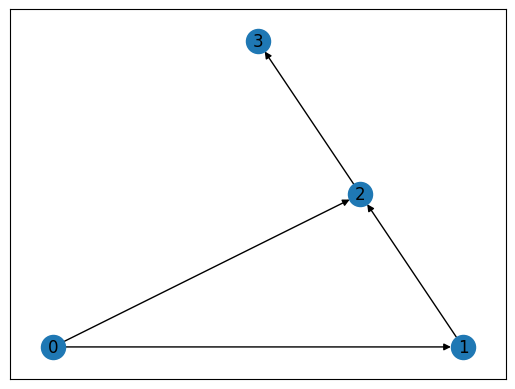

In [12]:
true_adj_matrix = load_data(root_path, DataEnum.TRUE_ADJACENCY)

true_graph = nx.from_numpy_matrix(true_adj_matrix.cpu().numpy(), create_using=nx.DiGraph)
nx.draw_networkx(true_graph, pos=nx.planar_layout(true_graph), with_labels=True, arrows=True)

Display the graph learned by DECI

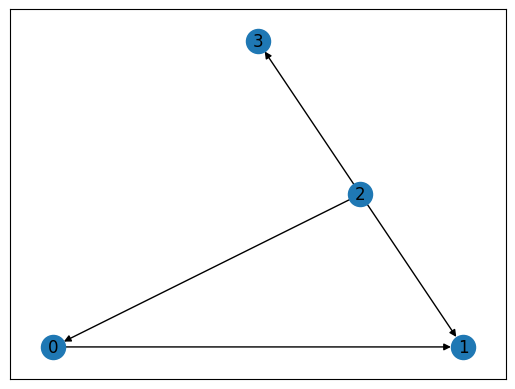

In [13]:
vardist = adjacency_dist()
graph = nx.from_numpy_matrix(vardist.mode.cpu().numpy(), create_using=nx.DiGraph)
nx.draw_networkx(graph, pos=nx.planar_layout(true_graph), with_labels=True, arrows=True)